In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
siddharthjiyani_ccmt_dataset_for_crop_pest_and_disease_detection_path = kagglehub.dataset_download('siddharthjiyani/ccmt-dataset-for-crop-pest-and-disease-detection')

print('Data source import complete.')


100%|██████████| 6.60G/6.60G [05:11<00:00, 22.8MB/s]

Extracting files...


Data source import complete.


In [3]:
print(siddharthjiyani_ccmt_dataset_for_crop_pest_and_disease_detection_path)
import os
os.listdir(siddharthjiyani_ccmt_dataset_for_crop_pest_and_disease_detection_path)


/root/.cache/kagglehub/datasets/siddharthjiyani/ccmt-dataset-for-crop-pest-and-disease-detection/versions/1


['train', 'valid']

In [4]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # or "3" to hide even more

import tensorflow as tf

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, models

In [6]:
TRAIN_DIR= os.path.join(
    siddharthjiyani_ccmt_dataset_for_crop_pest_and_disease_detection_path,
    'train'
)

VAL_DIR = os.path.join(
    siddharthjiyani_ccmt_dataset_for_crop_pest_and_disease_detection_path,
    'valid'
)


# Exploratory Data Analysis

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
import json

In [8]:
def analyze_directory_structure(base_dir):
    """Analyze the dataset directory structure"""

    classes = sorted(os.listdir(base_dir))
    class_counts = {}

    for cls in classes:
        cls_path = os.path.join(base_dir, cls)
        if os.path.isdir(cls_path):
            count = len([f for f in os.listdir(cls_path)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[cls] = count

    return classes, class_counts

In [9]:
def plot_class_distribution(train_counts, val_counts, save_path='class_distribution.png'):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Train distribution
    classes = list(train_counts.keys())
    train_values = list(train_counts.values())

    axes[0].barh(classes, train_values, color='steelblue')
    axes[0].set_xlabel('Number of Images', fontsize=12)
    axes[0].set_title(f'Training Set Distribution\nTotal: {sum(train_values)} images',
                     fontsize=14, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)

    # Val distribution
    val_values = list(val_counts.values())
    axes[1].barh(classes, val_values, color='coral')
    axes[1].set_xlabel('Number of Images', fontsize=12)
    axes[1].set_title(f'Validation Set Distribution\nTotal: {sum(val_values)} images',
                     fontsize=14, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved class distribution plot to {save_path}")
    plt.show()


In [10]:
def analyze_class_balance(class_counts):
    counts = list(class_counts.values())

    stats = {
        'total_images': sum(counts),
        'num_classes': len(counts),
        'min_samples': min(counts),
        'max_samples': max(counts),
        'mean_samples': np.mean(counts),
        'median_samples': np.median(counts),
        'std_samples': np.std(counts),
        'imbalance_ratio': max(counts) / min(counts)
    }

    print("\nClass Balance Statistics:")
    print(f"   Total Images: {stats['total_images']}")
    print(f"   Number of Classes: {stats['num_classes']}")
    print(f"   Samples per class - Min: {stats['min_samples']}, Max: {stats['max_samples']}")
    print(f"   Mean samples per class: {stats['mean_samples']:.1f}")
    print(f"   Std deviation: {stats['std_samples']:.1f}")
    print(f"   Imbalance ratio (max/min): {stats['imbalance_ratio']:.2f}")


    return stats


In [11]:
def visualize_sample_images(data_dir, classes, samples_per_class=3, save_path='sample_images.png'):
    n_classes = len(classes)
    fig, axes = plt.subplots(n_classes, samples_per_class, figsize=(12, n_classes * 2))
    if n_classes == 1:
        axes = axes.reshape(1, -1)

    for i, cls in enumerate(classes):
        cls_path = os.path.join(data_dir, cls)
        if not os.path.isdir(cls_path):
            continue

        images = [f for f in os.listdir(cls_path)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        sampled = np.random.choice(images, min(samples_per_class, len(images)), replace=False)

        for j, img_name in enumerate(sampled):
            img_path = os.path.join(cls_path, img_name)
            try:
                img = Image.open(img_path)
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                if j == 0:
                    axes[i, j].set_title(cls, fontsize=8, loc='left')
            except Exception as e:
                print(f"   Error loading {img_path}: {e}")
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved sample images to {save_path}")
    plt.show()


Training Set Analysis

Class Balance Statistics:
   Total Images: 80271
   Number of Classes: 22
   Samples per class - Min: 830, Max: 9373
   Mean samples per class: 3648.7
   Std deviation: 2153.6
   Imbalance ratio (max/min): 11.29

Validation Set Analysis

Class Balance Statistics:
   Total Images: 24981
   Number of Classes: 22
   Samples per class - Min: 211, Max: 2623
   Mean samples per class: 1135.5
   Std deviation: 623.5
   Imbalance ratio (max/min): 12.43
Saved class distribution plot to class_distribution.png


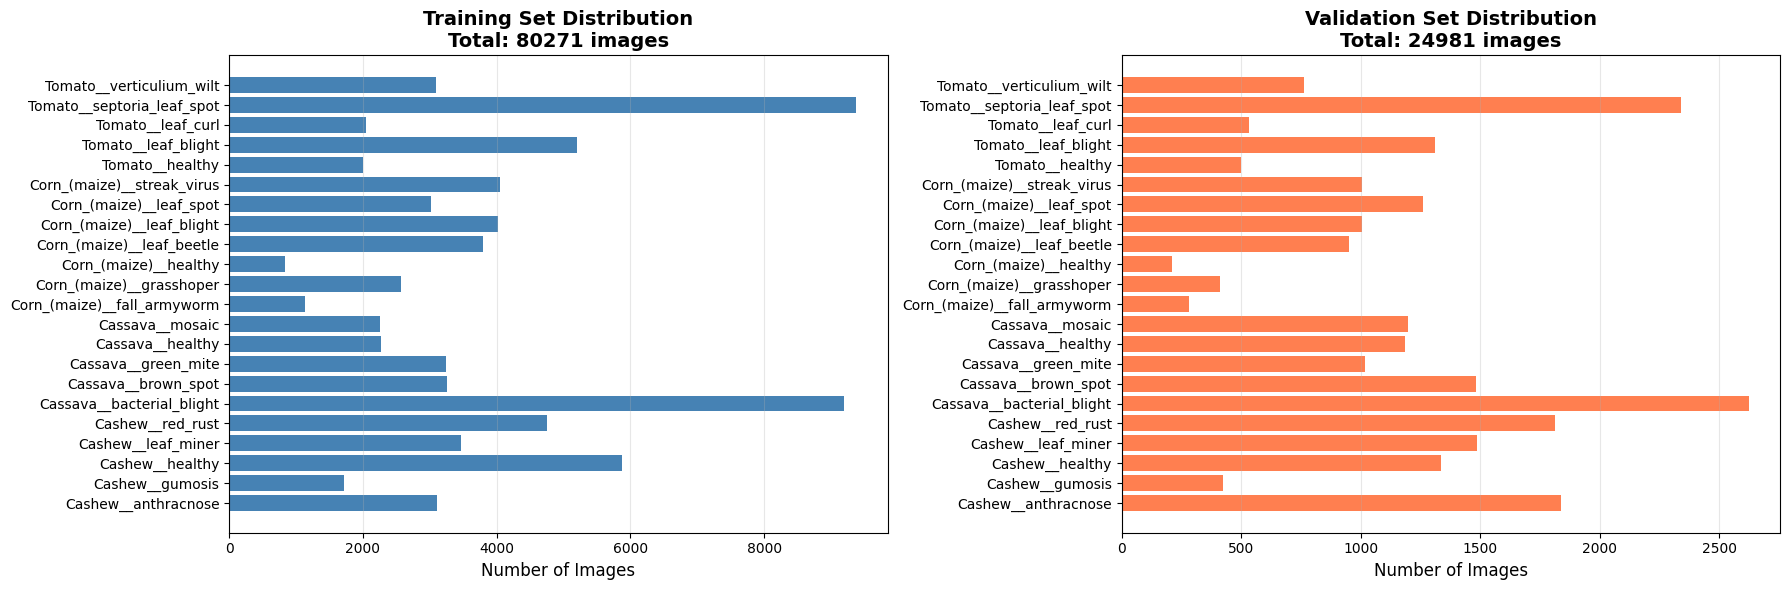

Saved sample images to sample_images.png


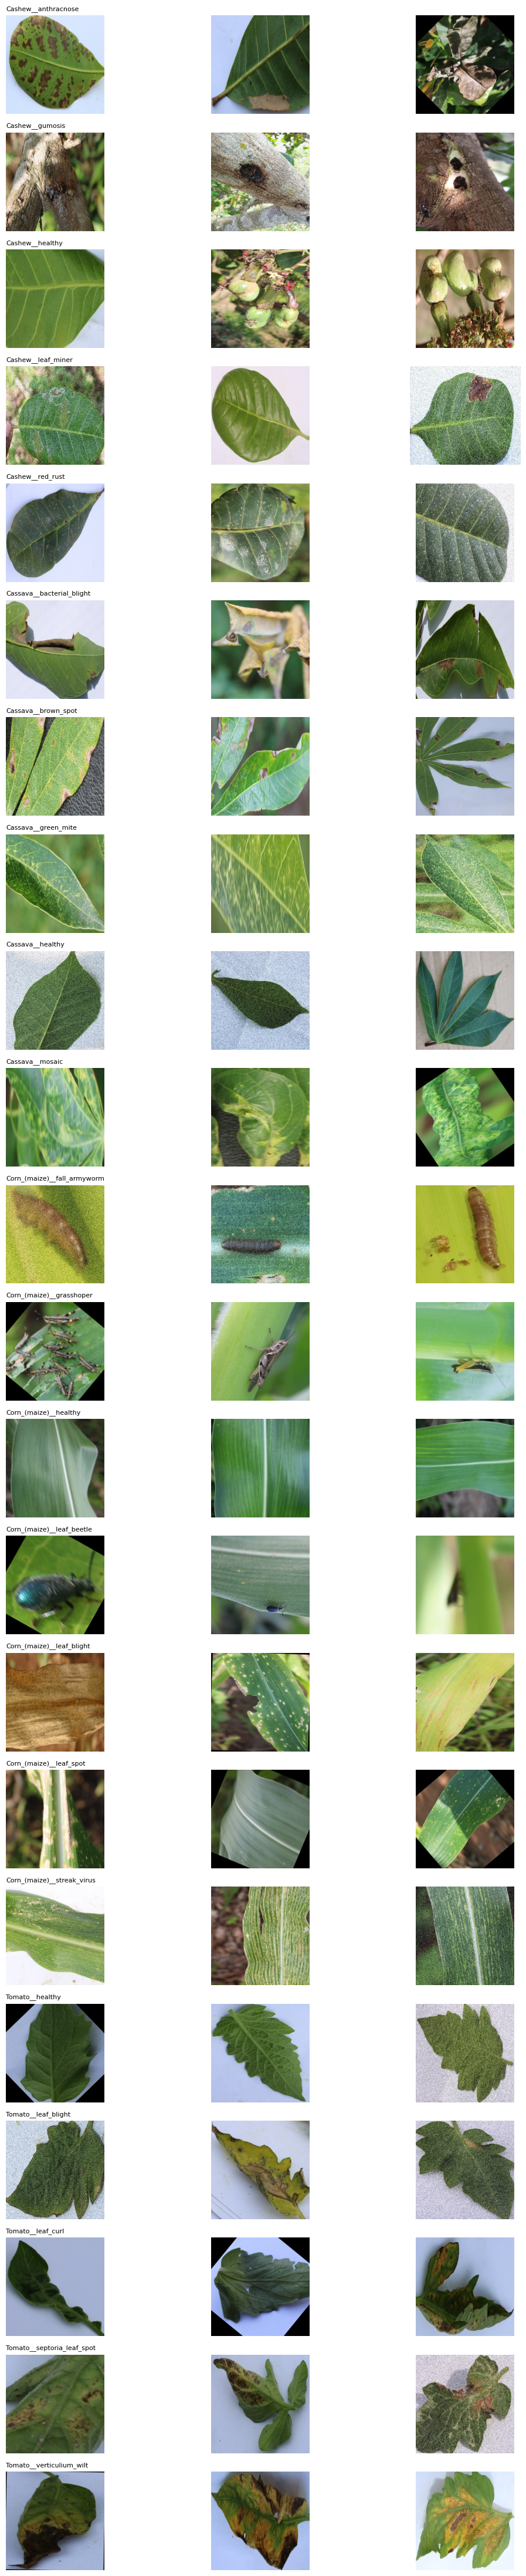

In [12]:
# Analyze train set
print("\nTraining Set Analysis")
train_classes, train_counts = analyze_directory_structure(TRAIN_DIR)
train_stats = analyze_class_balance(train_counts)

# Analyze validation set
print("\nValidation Set Analysis")
val_classes, val_counts = analyze_directory_structure(VAL_DIR)
val_stats = analyze_class_balance(val_counts)

# Plot class distributions
plot_class_distribution(train_counts, val_counts)


# Visualize sample images
visualize_sample_images(TRAIN_DIR, train_classes, samples_per_class=3)


# Model Building

In [13]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, models
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve
)
import seaborn as sns
from sklearn.preprocessing import label_binarize

In [14]:
# Model parameters
NUM_CLASSES = 22
INPUT_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

Using device: cuda


In [15]:
class CropDiseaseDataset(Dataset):
    """Custom Dataset for CCMT Crop Disease images"""
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Get all disease classes
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        print(f"Found {len(self.classes)} disease classes:")
        for cls in self.classes:
            print(f"  - {cls}")

        # Load all image paths and labels
        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            if os.path.isdir(label_dir):
                for img_name in os.listdir(label_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(label_dir, img_name))
                        self.labels.append(self.class_to_idx[label_name])

        print(f"Total images loaded: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [16]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


In [17]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(INPUT_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transforms = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [18]:
class CropDiseaseClassifier(nn.Module):
    """Crop Disease Classifier based on MobileNetV2"""
    def __init__(self, num_classes=22, size_inner=128, droprate=0.3):
        super(CropDiseaseClassifier, self).__init__()

        # Load pre-trained MobileNetV2
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        self.base_model.classifier = nn.Identity()

        # Custom classification head
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.inner = nn.Linear(1280, size_inner)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(droprate)
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output_layer(x)
        return x

In [19]:
def get_predictions_and_labels(model, data_loader, device):
    """Get all predictions and true labels from a data loader"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

In [20]:
def plot_confusion_matrix(y_true, y_pred, classes, save_path='confusion_matrix.png'):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(20, 18))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix - Crop Disease Detection', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    return cm

In [21]:
def plot_roc_curves(y_true, y_probs, classes, save_path='roc_curves.png'):
    """Plot ROC curves for all classes"""
    # Binarize labels for multiclass ROC
    y_true_bin = label_binarize(y_true, classes=range(len(classes)))

    # Calculate ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    fig, axes = plt.subplots(4, 6, figsize=(24, 16))
    axes = axes.flatten()

    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_probs[:, i])

        axes[i].plot(fpr[i], tpr[i], color='darkorange', lw=2,
                     label=f'AUC = {roc_auc[i]:.3f}')
        axes[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[i].set_xlim([0.0, 1.0])
        axes[i].set_ylim([0.0, 1.05])
        axes[i].set_xlabel('False Positive Rate')
        axes[i].set_ylabel('True Positive Rate')
        axes[i].set_title(f'{classes[i][:20]}', fontsize=8)
        axes[i].legend(loc="lower right", fontsize=8)
        axes[i].grid(True, alpha=0.3)

    # Hide extra subplots if any
    for i in range(len(classes), len(axes)):
        axes[i].axis('off')

    plt.suptitle('ROC Curves for Each Disease Class', fontsize=16, y=0.995)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    # Calculate macro and micro average ROC AUC
    macro_roc_auc = roc_auc_score(y_true_bin, y_probs, average='macro')
    micro_roc_auc = roc_auc_score(y_true_bin, y_probs, average='micro')

    return roc_auc, macro_roc_auc, micro_roc_auc

In [22]:
def plot_precision_recall_curves(y_true, y_probs, classes, save_path='pr_curves.png'):
    """Plot Precision-Recall curves for all classes"""
    # Binarize labels
    y_true_bin = label_binarize(y_true, classes=range(len(classes)))

    # Calculate PR curve and AP for each class
    precision = {}
    recall = {}
    pr_auc = {}

    fig, axes = plt.subplots(4, 6, figsize=(24, 16))
    axes = axes.flatten()

    for i in range(len(classes)):
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
        pr_auc[i] = average_precision_score(y_true_bin[:, i], y_probs[:, i])

        axes[i].plot(recall[i], precision[i], color='darkorange', lw=2,
                     label=f'AP = {pr_auc[i]:.3f}')
        axes[i].set_xlim([0.0, 1.0])
        axes[i].set_ylim([0.0, 1.05])
        axes[i].set_xlabel('Recall')
        axes[i].set_ylabel('Precision')
        axes[i].set_title(f'{classes[i][:20]}', fontsize=8)
        axes[i].legend(loc="lower left", fontsize=8)
        axes[i].grid(True, alpha=0.3)

    # Hide extra subplots if any
    for i in range(len(classes), len(axes)):
        axes[i].axis('off')

    plt.suptitle('Precision-Recall Curves for Each Disease Class', fontsize=16, y=0.995)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    # Calculate macro and micro average PR AUC
    macro_pr_auc = average_precision_score(y_true_bin, y_probs, average='macro')
    micro_pr_auc = average_precision_score(y_true_bin, y_probs, average='micro')

    return pr_auc, macro_pr_auc, micro_pr_auc

In [23]:
def comprehensive_evaluation(model, data_loader, classes, device,
                            dataset_name='Validation'):
    y_true, y_pred, y_probs = get_predictions_and_labels(model, data_loader, device)

    print("Classification Report")
    report = classification_report(y_true, y_pred, target_names=classes,
                                   digits=4, zero_division=0)
    print(report)

    print("\nConfusion Matrix")
    cm = plot_confusion_matrix(y_true, y_pred, classes,
                               save_path=f'confusion_matrix_{dataset_name.lower()}.png')

    # Print per-class accuracy from confusion matrix
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    print("\nPer-class Accuracy:")
    for i, (cls, acc) in enumerate(zip(classes, class_accuracies)):
        print(f"  {cls:30s}: {acc:.4f} ({cm[i,i]}/{cm.sum(axis=1)[i]})")

    print("\nROC-AUC Scores")
    roc_auc_dict, macro_roc_auc, micro_roc_auc = plot_roc_curves(
        y_true, y_probs, classes,
        save_path=f'roc_curves_{dataset_name.lower()}.png'
    )

    print(f"\nMacro-average ROC-AUC: {macro_roc_auc:.4f}")
    print(f"Micro-average ROC-AUC: {micro_roc_auc:.4f}")
    print("\nPer-class ROC-AUC:")
    for i, (cls, auc) in enumerate(zip(classes, roc_auc_dict.values())):
        print(f"  {cls:30s}: {auc:.4f}")

    print("\nPrecision Recall AUC Scores")
    pr_auc_dict, macro_pr_auc, micro_pr_auc = plot_precision_recall_curves(
        y_true, y_probs, classes,
        save_path=f'pr_curves_{dataset_name.lower()}.png'
    )

    print(f"\nMacro-average PR-AUC: {macro_pr_auc:.4f}")
    print(f"Micro-average PR-AUC: {micro_pr_auc:.4f}")
    print("\nPer-class PR-AUC (Average Precision):")
    for i, (cls, auc) in enumerate(zip(classes, pr_auc_dict.values())):
        print(f"  {cls:30s}: {auc:.4f}")

    # Summary Statistics
    overall_accuracy = (y_pred == y_true).sum() / len(y_true)
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"Total Samples: {len(y_true)}")
    print(f"Correctly Classified: {(y_pred == y_true).sum()}")
    print(f"Misclassified: {(y_pred != y_true).sum()}")


    return {
        'accuracy': overall_accuracy,
        'classification_report': report,
        'confusion_matrix': cm,
        'roc_auc': roc_auc_dict,
        'macro_roc_auc': macro_roc_auc,
        'micro_roc_auc': micro_roc_auc,
        'pr_auc': pr_auc_dict,
        'macro_pr_auc': macro_pr_auc,
        'micro_pr_auc': micro_pr_auc
    }



In [24]:
def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion,
                       num_epochs, device, save_best=True):
    """Training loop with validation"""
    best_val_accuracy = 0.0
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        if save_best and val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            checkpoint_path = f'crop_disease_model_epoch{epoch+1:02d}_acc{val_acc:.3f}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Checkpoint saved: {checkpoint_path}')

    print(f'\nTraining complete! Best validation accuracy: {best_val_accuracy:.4f}')
    return history


In [25]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(history['train_acc'], label='Train Acc')
    axes[1].plot(history['val_acc'], label='Val Acc')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

In [26]:
train_dataset = CropDiseaseDataset(data_dir=TRAIN_DIR, transform=train_transforms)
val_dataset = CropDiseaseDataset(data_dir=VAL_DIR, transform=val_transforms)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=3, pin_memory=True, persistent_workers=True
)

val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=3, pin_memory=True, persistent_workers=True
)


Found 22 disease classes:
  - Cashew__anthracnose
  - Cashew__gumosis
  - Cashew__healthy
  - Cashew__leaf_miner
  - Cashew__red_rust
  - Cassava__bacterial_blight
  - Cassava__brown_spot
  - Cassava__green_mite
  - Cassava__healthy
  - Cassava__mosaic
  - Corn_(maize)__fall_armyworm
  - Corn_(maize)__grasshoper
  - Corn_(maize)__healthy
  - Corn_(maize)__leaf_beetle
  - Corn_(maize)__leaf_blight
  - Corn_(maize)__leaf_spot
  - Corn_(maize)__streak_virus
  - Tomato__healthy
  - Tomato__leaf_blight
  - Tomato__leaf_curl
  - Tomato__septoria_leaf_spot
  - Tomato__verticulium_wilt
Total images loaded: 80271
Found 22 disease classes:
  - Cashew__anthracnose
  - Cashew__gumosis
  - Cashew__healthy
  - Cashew__leaf_miner
  - Cashew__red_rust
  - Cassava__bacterial_blight
  - Cassava__brown_spot
  - Cassava__green_mite
  - Cassava__healthy
  - Cassava__mosaic
  - Corn_(maize)__fall_armyworm
  - Corn_(maize)__grasshoper
  - Corn_(maize)__healthy
  - Corn_(maize)__leaf_beetle
  - Corn_(maize)__

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [27]:
model = CropDiseaseClassifier(num_classes=NUM_CLASSES, size_inner=128, droprate=0.3)
model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 187MB/s]



Starting training for 10 epochs...
Batch size: 32
Learning rate: 0.001
Device: cuda

Epoch 1/10
  Train Loss: 1.3460, Train Acc: 0.5549
  Val Loss: 0.9025, Val Acc: 0.6755
Checkpoint saved: crop_disease_model_epoch01_acc0.676.pth
Epoch 2/10
  Train Loss: 1.1312, Train Acc: 0.6134
  Val Loss: 0.8845, Val Acc: 0.6806
Checkpoint saved: crop_disease_model_epoch02_acc0.681.pth
Epoch 3/10
  Train Loss: 1.0881, Train Acc: 0.6277
  Val Loss: 0.8383, Val Acc: 0.6970
Checkpoint saved: crop_disease_model_epoch03_acc0.697.pth
Epoch 4/10
  Train Loss: 1.0698, Train Acc: 0.6325
  Val Loss: 0.8263, Val Acc: 0.7012
Checkpoint saved: crop_disease_model_epoch04_acc0.701.pth
Epoch 5/10
  Train Loss: 1.0524, Train Acc: 0.6364
  Val Loss: 0.8281, Val Acc: 0.7035
Checkpoint saved: crop_disease_model_epoch05_acc0.704.pth
Epoch 6/10
  Train Loss: 1.0335, Train Acc: 0.6432
  Val Loss: 0.7975, Val Acc: 0.7121
Checkpoint saved: crop_disease_model_epoch06_acc0.712.pth
Epoch 7/10
  Train Loss: 1.0295, Train Acc: 

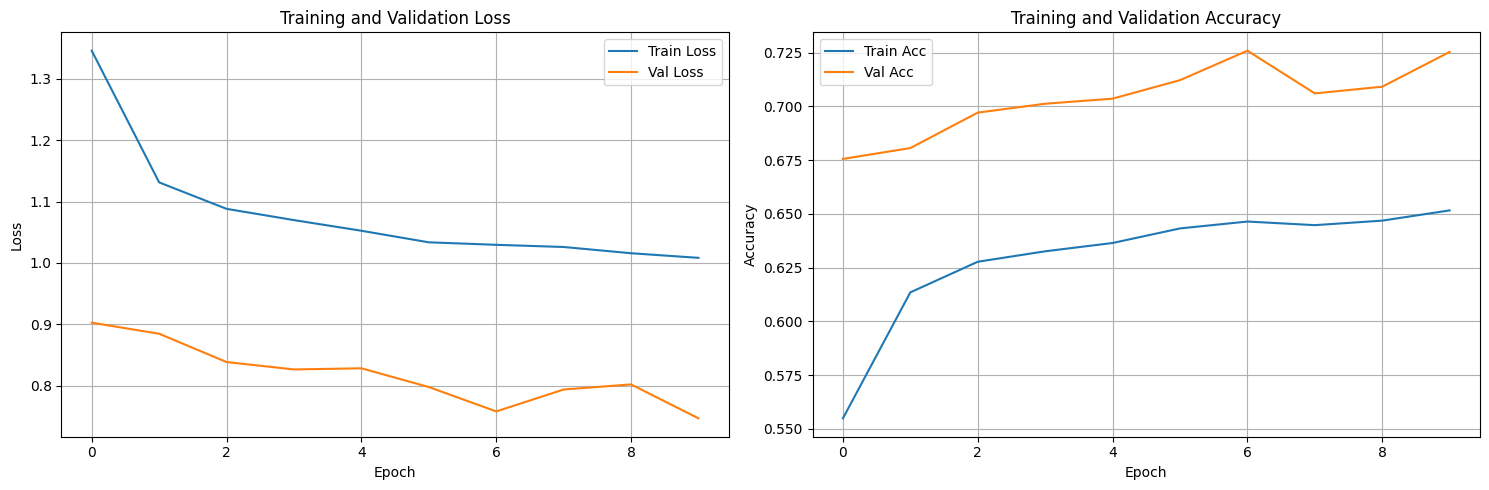

In [28]:
print(f"\nStarting training for {NUM_EPOCHS} epochs...")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Device: {DEVICE}\n")

# Train model
history = train_and_evaluate(
    model=model, optimizer=optimizer,
    train_loader=train_loader, val_loader=val_loader,
    criterion=criterion, num_epochs=NUM_EPOCHS,
    device=DEVICE, save_best=True
)

# Plot training history
plot_training_history(history)


Classification Report
                             precision    recall  f1-score   support

        Cashew__anthracnose     0.8007    0.7084    0.7517      1838
            Cashew__gumosis     0.9676    0.9835    0.9755       425
            Cashew__healthy     0.8156    0.9499    0.8776      1336
         Cashew__leaf_miner     0.7984    0.7270    0.7610      1487
           Cashew__red_rust     0.9328    0.9554    0.9439      1815
  Cassava__bacterial_blight     0.6124    0.8898    0.7255      2623
        Cassava__brown_spot     0.8267    0.6271    0.7132      1483
        Cassava__green_mite     0.7751    0.7333    0.7537      1020
           Cassava__healthy     0.9120    0.8319    0.8701      1184
            Cassava__mosaic     0.8831    0.7117    0.7882      1200
Corn_(maize)__fall_armyworm     0.6630    0.6303    0.6462       284
   Corn_(maize)__grasshoper     0.8299    0.7956    0.8124       411
      Corn_(maize)__healthy     0.6561    0.5877    0.6200       211
  Corn_(mai

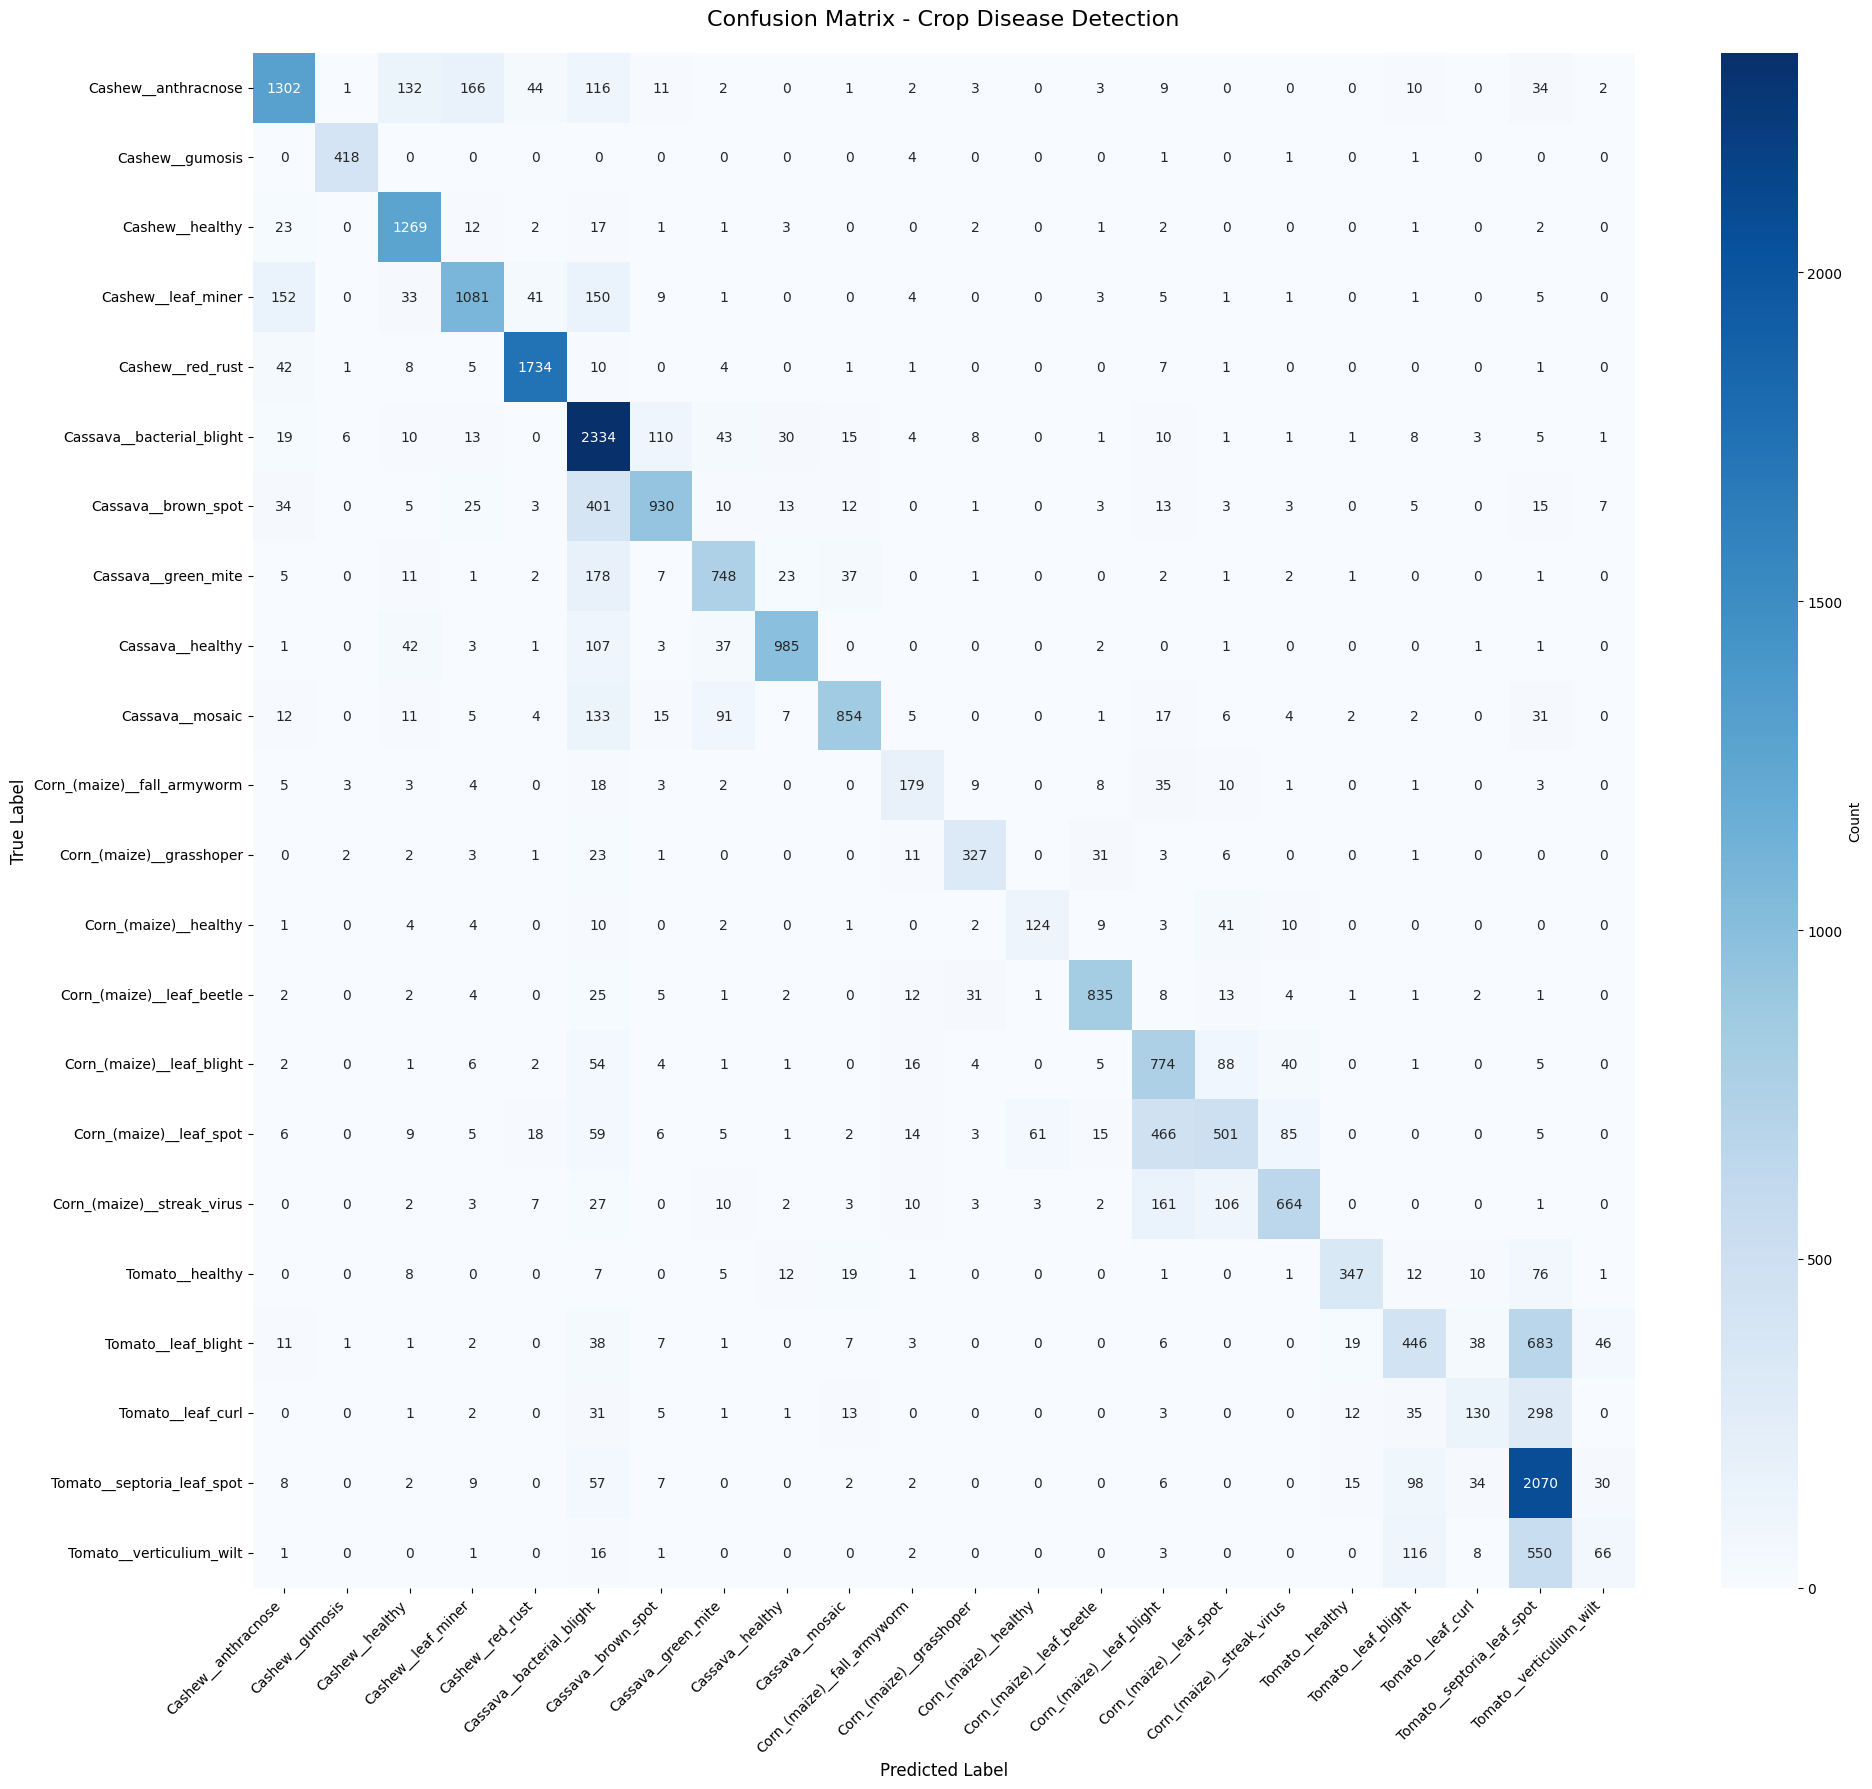


Per-class Accuracy:
  Cashew__anthracnose           : 0.7084 (1302/1838)
  Cashew__gumosis               : 0.9835 (418/425)
  Cashew__healthy               : 0.9499 (1269/1336)
  Cashew__leaf_miner            : 0.7270 (1081/1487)
  Cashew__red_rust              : 0.9554 (1734/1815)
  Cassava__bacterial_blight     : 0.8898 (2334/2623)
  Cassava__brown_spot           : 0.6271 (930/1483)
  Cassava__green_mite           : 0.7333 (748/1020)
  Cassava__healthy              : 0.8319 (985/1184)
  Cassava__mosaic               : 0.7117 (854/1200)
  Corn_(maize)__fall_armyworm   : 0.6303 (179/284)
  Corn_(maize)__grasshoper      : 0.7956 (327/411)
  Corn_(maize)__healthy         : 0.5877 (124/211)
  Corn_(maize)__leaf_beetle     : 0.8789 (835/950)
  Corn_(maize)__leaf_blight     : 0.7709 (774/1004)
  Corn_(maize)__leaf_spot       : 0.3973 (501/1261)
  Corn_(maize)__streak_virus    : 0.6614 (664/1004)
  Tomato__healthy               : 0.6940 (347/500)
  Tomato__leaf_blight           : 0.3407 (44

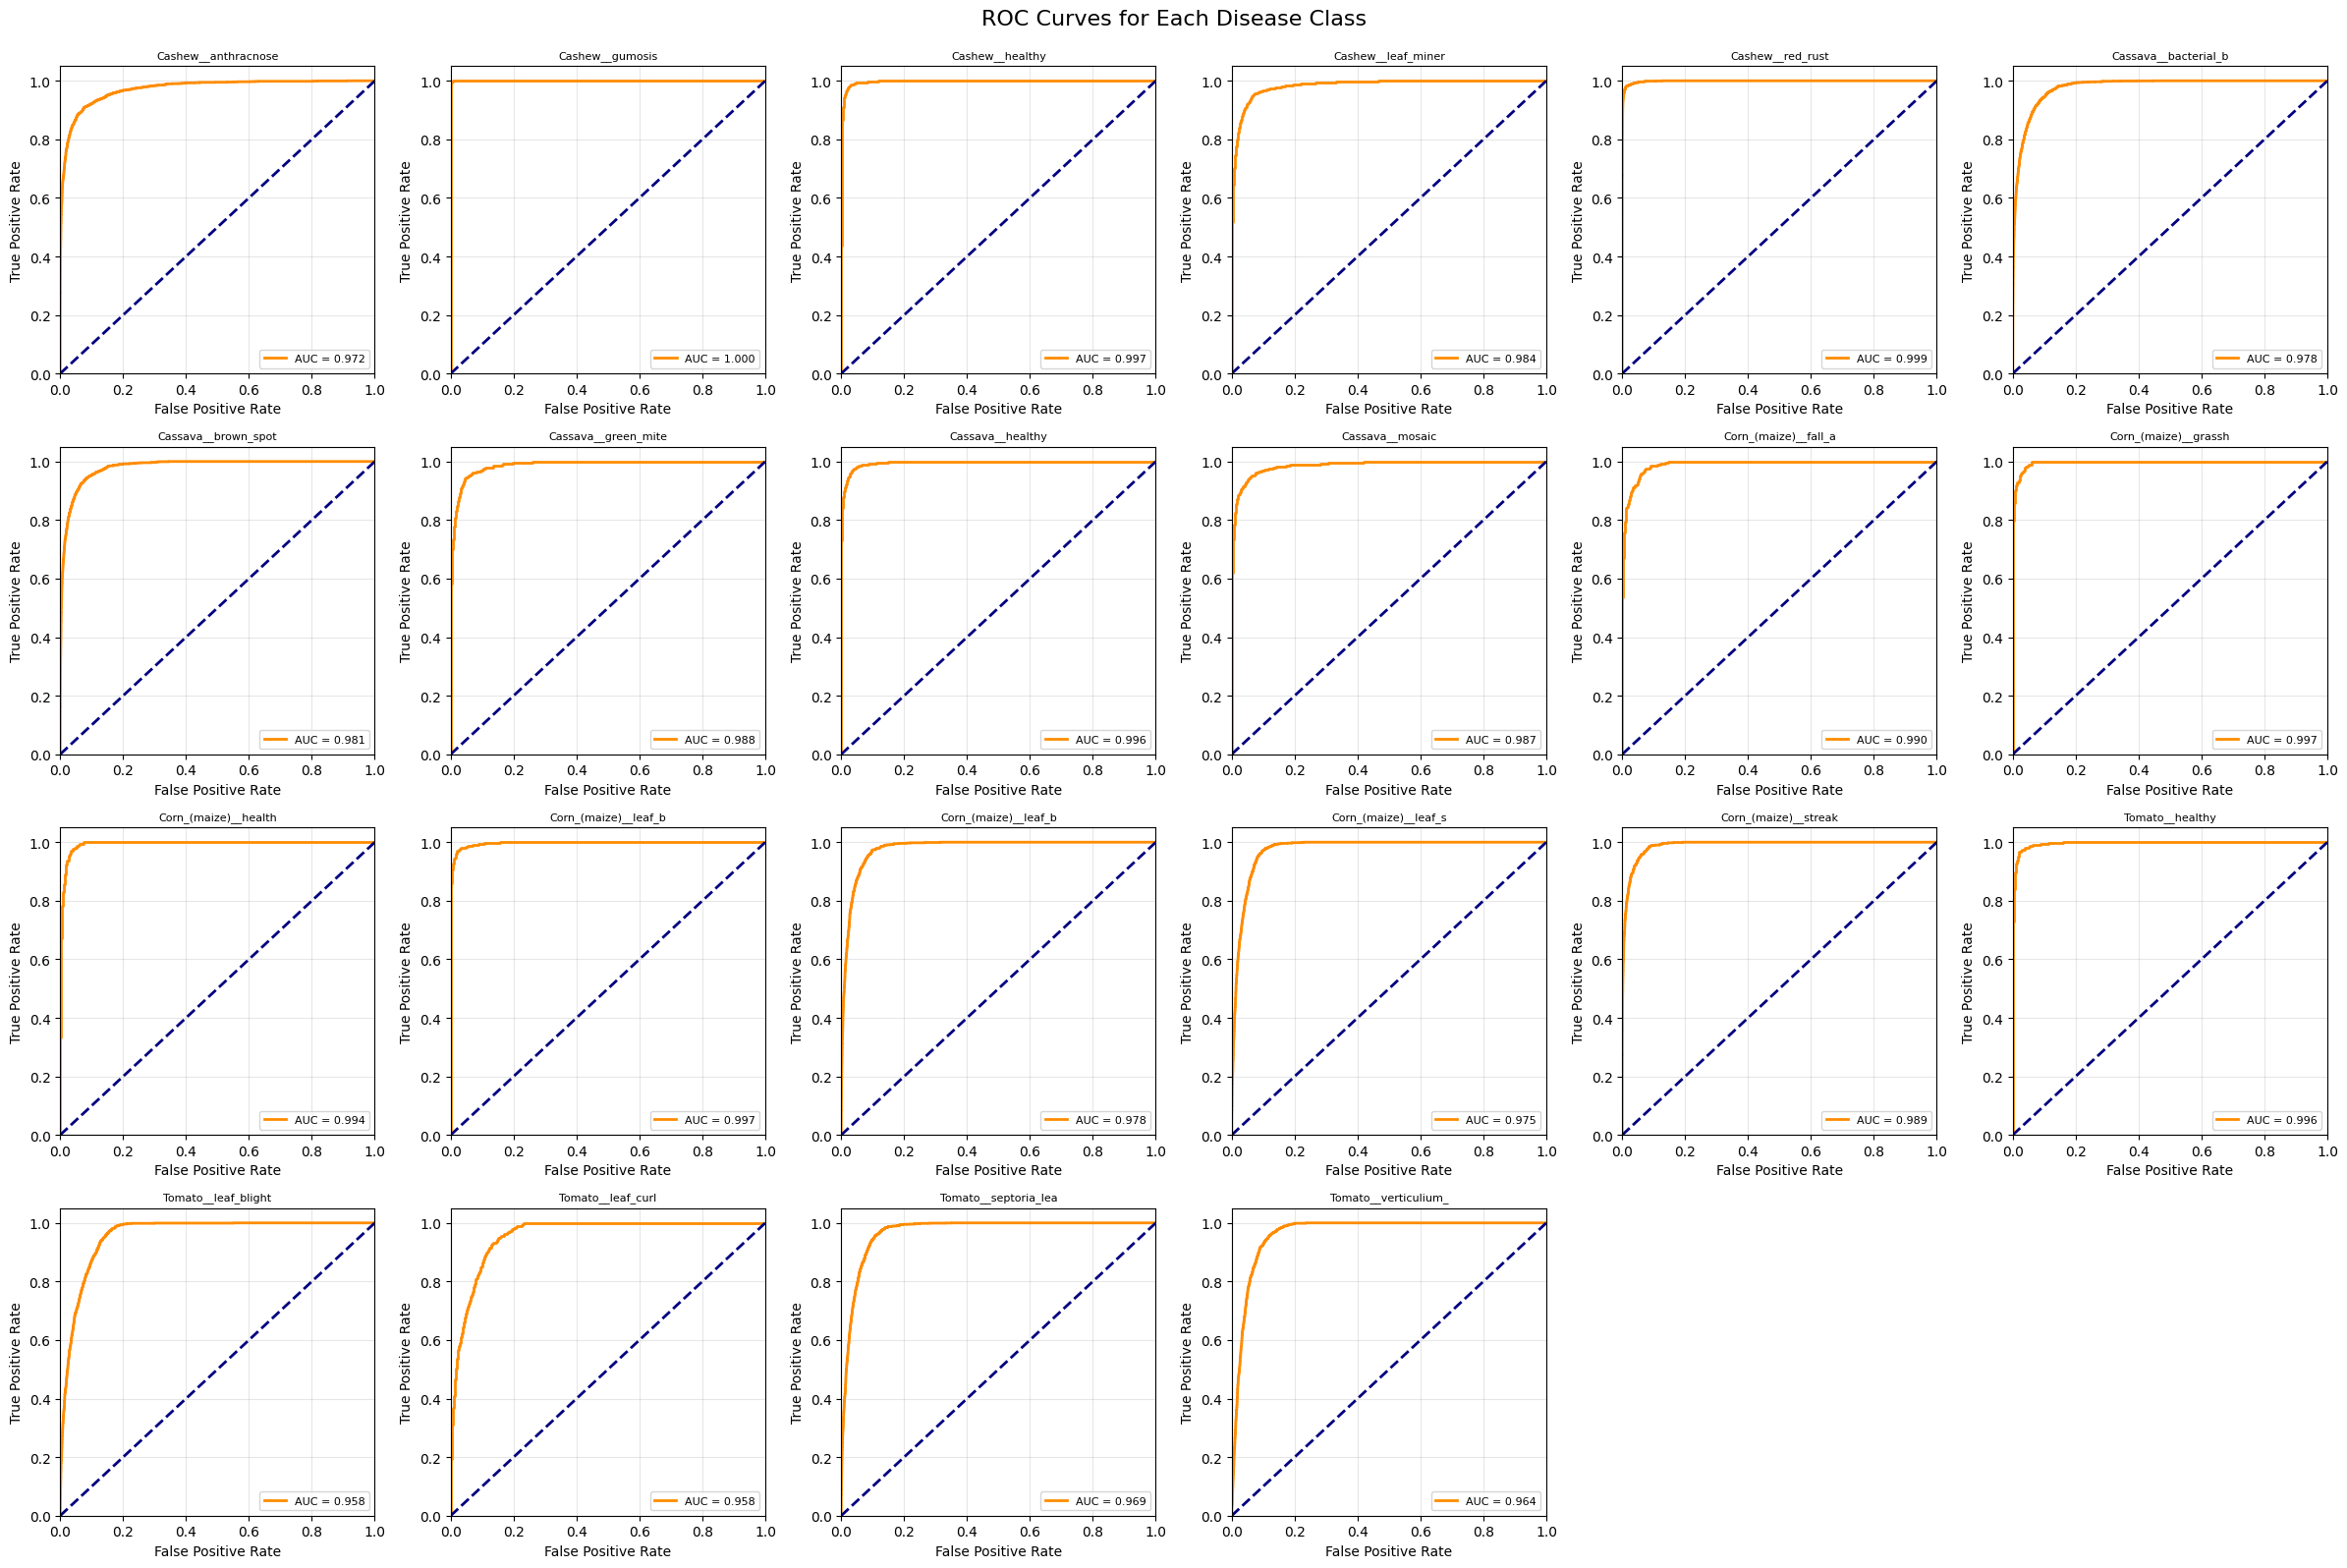


Macro-average ROC-AUC: 0.9839
Micro-average ROC-AUC: 0.9866

Per-class ROC-AUC:
  Cashew__anthracnose           : 0.9724
  Cashew__gumosis               : 0.9999
  Cashew__healthy               : 0.9969
  Cashew__leaf_miner            : 0.9837
  Cashew__red_rust              : 0.9986
  Cassava__bacterial_blight     : 0.9780
  Cassava__brown_spot           : 0.9811
  Cassava__green_mite           : 0.9877
  Cassava__healthy              : 0.9956
  Cassava__mosaic               : 0.9868
  Corn_(maize)__fall_armyworm   : 0.9903
  Corn_(maize)__grasshoper      : 0.9965
  Corn_(maize)__healthy         : 0.9940
  Corn_(maize)__leaf_beetle     : 0.9971
  Corn_(maize)__leaf_blight     : 0.9783
  Corn_(maize)__leaf_spot       : 0.9749
  Corn_(maize)__streak_virus    : 0.9891
  Tomato__healthy               : 0.9959
  Tomato__leaf_blight           : 0.9584
  Tomato__leaf_curl             : 0.9580
  Tomato__septoria_leaf_spot    : 0.9695
  Tomato__verticulium_wilt      : 0.9638

Precision Recall

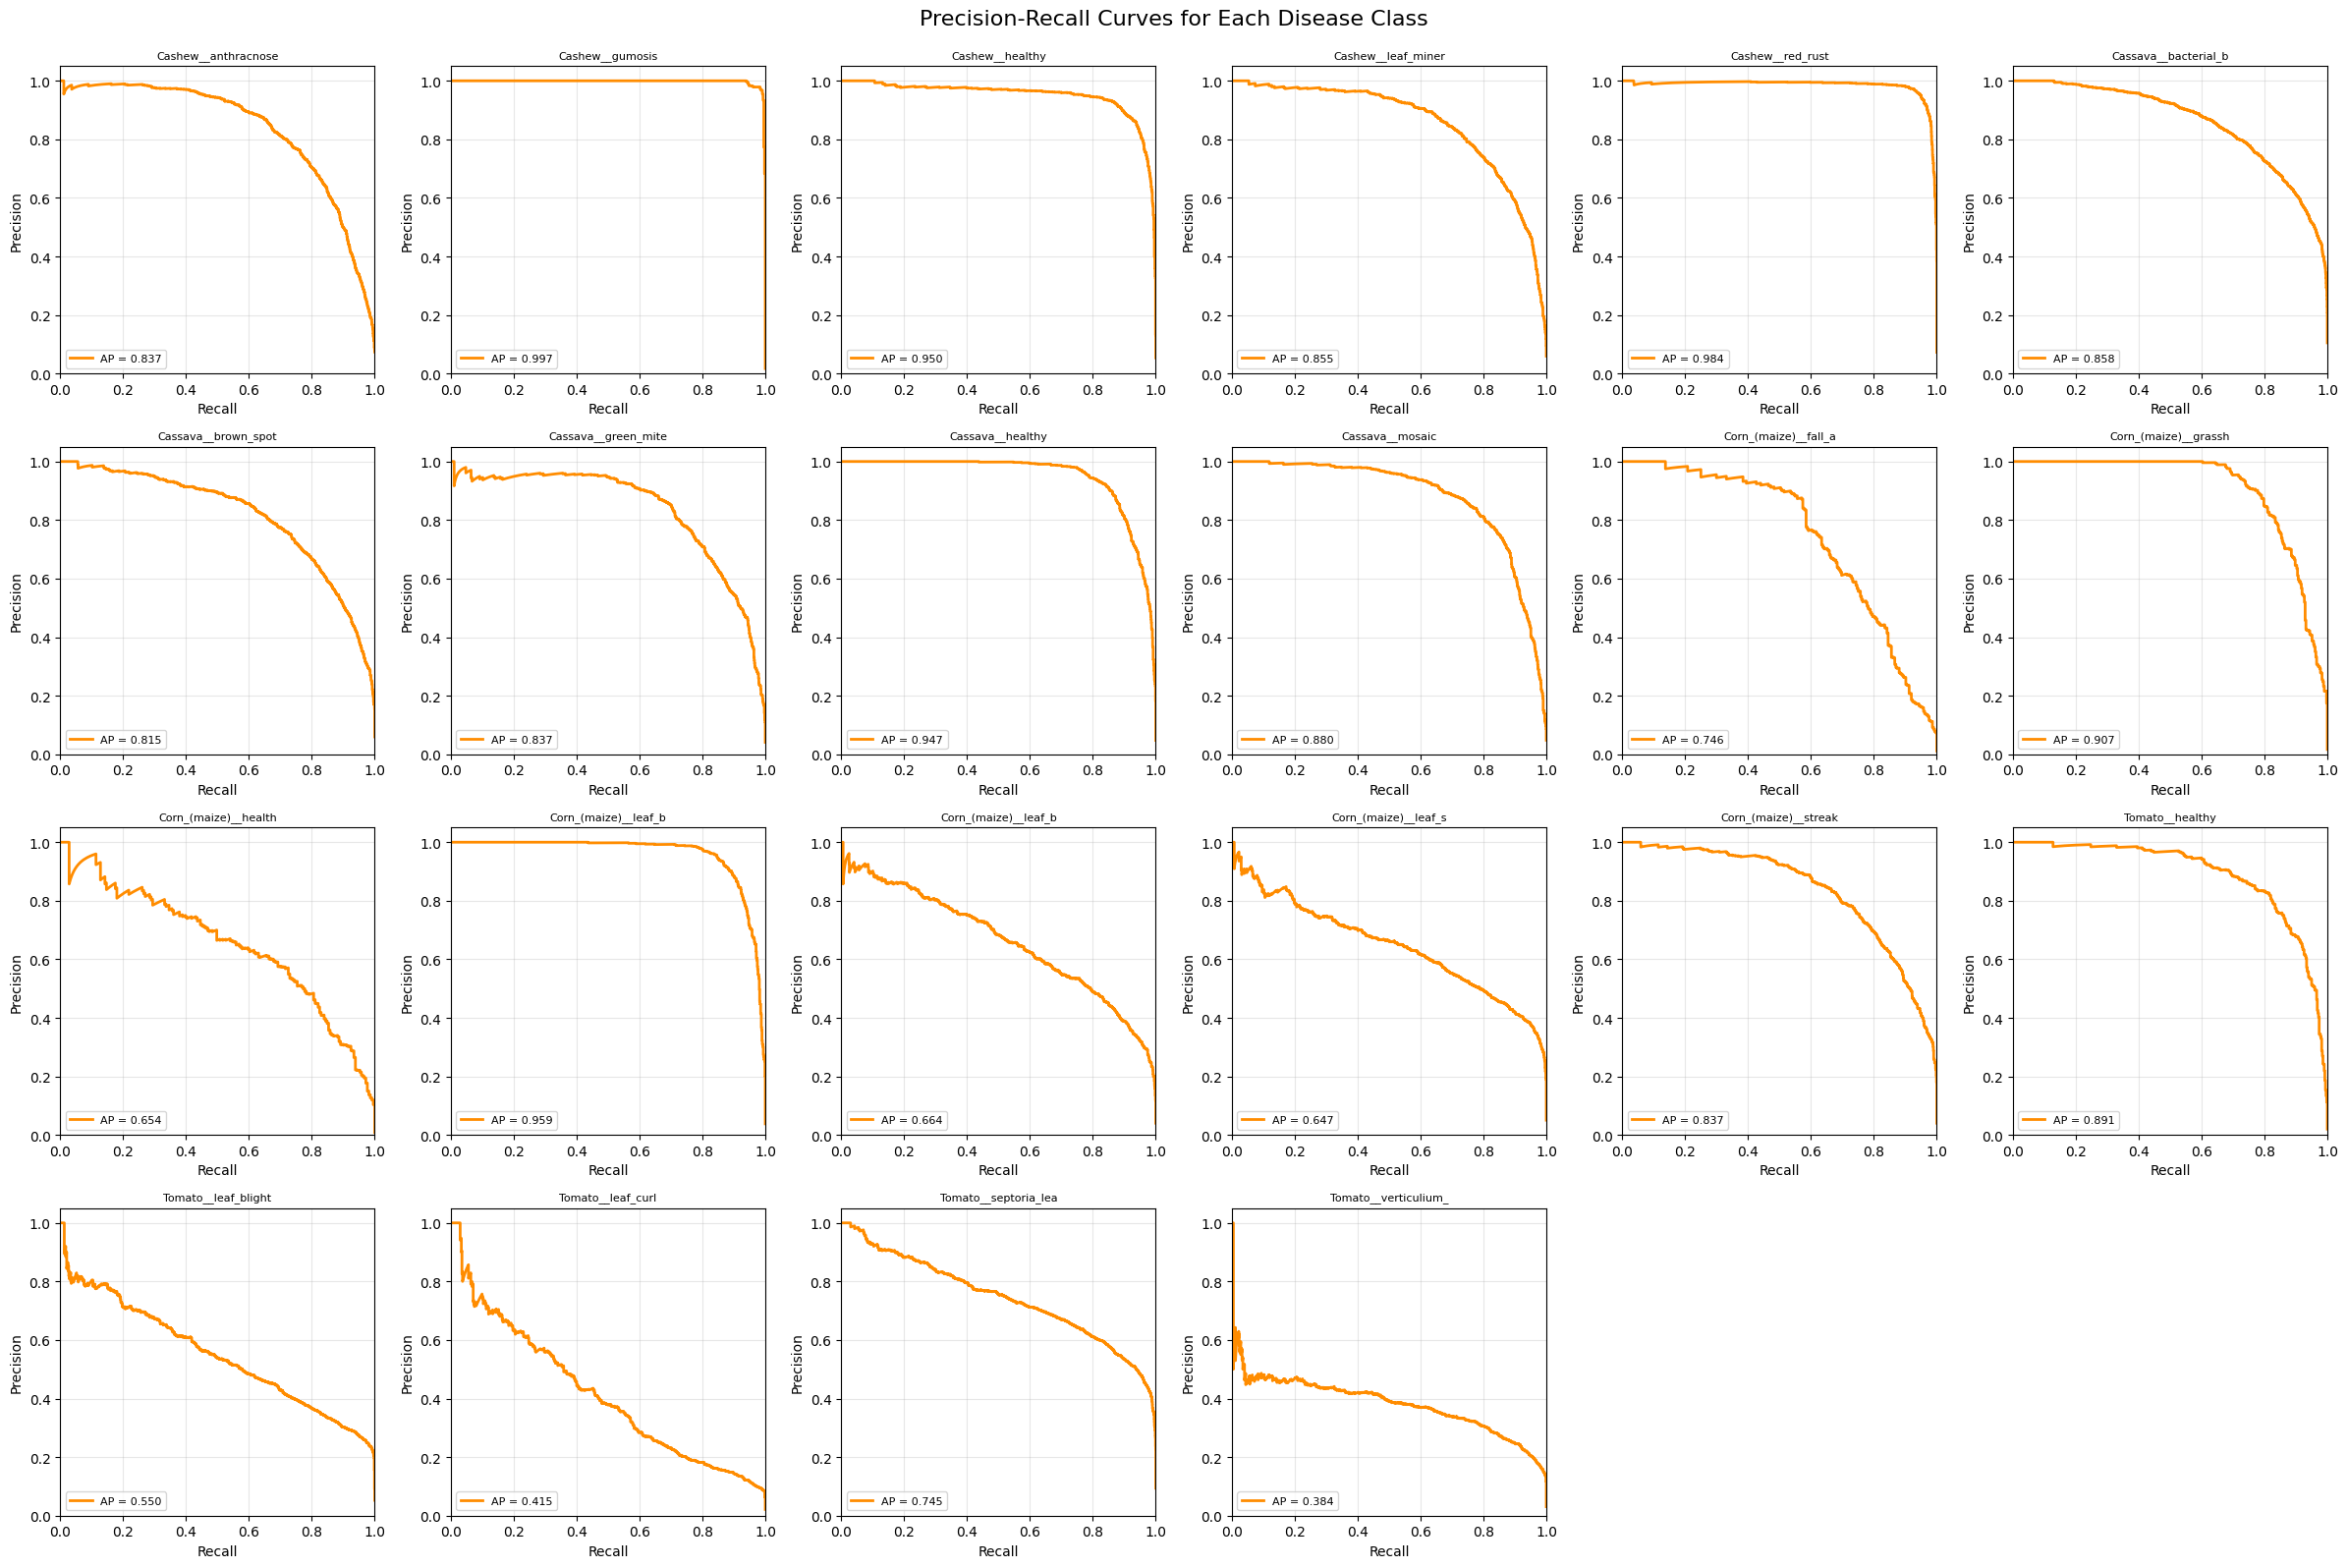


Macro-average PR-AUC: 0.7891
Micro-average PR-AUC: 0.8288

Per-class PR-AUC (Average Precision):
  Cashew__anthracnose           : 0.8375
  Cashew__gumosis               : 0.9975
  Cashew__healthy               : 0.9501
  Cashew__leaf_miner            : 0.8553
  Cashew__red_rust              : 0.9835
  Cassava__bacterial_blight     : 0.8583
  Cassava__brown_spot           : 0.8146
  Cassava__green_mite           : 0.8369
  Cassava__healthy              : 0.9473
  Cassava__mosaic               : 0.8796
  Corn_(maize)__fall_armyworm   : 0.7463
  Corn_(maize)__grasshoper      : 0.9067
  Corn_(maize)__healthy         : 0.6542
  Corn_(maize)__leaf_beetle     : 0.9590
  Corn_(maize)__leaf_blight     : 0.6637
  Corn_(maize)__leaf_spot       : 0.6470
  Corn_(maize)__streak_virus    : 0.8373
  Tomato__healthy               : 0.8907
  Tomato__leaf_blight           : 0.5499
  Tomato__leaf_curl             : 0.4150
  Tomato__septoria_leaf_spot    : 0.7452
  Tomato__verticulium_wilt      : 0.3837


In [29]:
# Comprehensive evaluation on validation set
eval_results = comprehensive_evaluation(
    model=model, data_loader=val_loader,
    classes=train_dataset.classes, device=DEVICE,
    dataset_name='Validation'
)

In [31]:
!pip install onnxruntime==1.23.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.2 MB/s eta 0:00:00


In [33]:
!pip install onnx onnxscript


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 12.0 MB/s eta 0:00:00


In [34]:
# Export to ONNX
model.eval()
dummy_input = torch.randn(1, 3, INPUT_SIZE, INPUT_SIZE).to(DEVICE)
onnx_path = "crop_disease_mobilenet.onnx"

torch.onnx.export(
    model, dummy_input, onnx_path, verbose=False,
    input_names=['input'], output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)


/tmp/ipython-input-3190607089.py:6: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


Applied 105 of general pattern rewrite rules.


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 20},
            producer_name='pytorch',
            producer_version='2.9.0+cu126',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"input"<FLOAT,[s77,3,224,224]>
            ),
            outputs=(
                %"output"<FLOAT,[s77,22]>
            ),
            initializers=(
                %"base_model.features.0.0.weight"<FLOAT,[32,3,3,3]>{Tensor(...)},
                %"base_model.features.1.conv.0.0.weight"<FLOAT,[32,1,3,3]>{Tensor(...)},
                %"base_model.features.1.conv.1.weight"<FLOAT,[16,32,1,1]>{Tensor(...)},
                %"base_model.features.2.conv.0.0.weight"<FLOAT,[96,16,1,1]>{Tensor(...)},
                %"base_model.features.2.conv.1.0.weight"<FLOAT,[96,1,3,3]>{Tensor(...)},
                %"base_model.features.2.conv.2.weight"<FLOAT,[24,96,1,1]>{Tensor(..

In [36]:
print(f"\nBest validation accuracy: {max(history['val_acc']):.4f}")
print(f"Final validation accuracy: {eval_results['accuracy']:.4f}")
print(f"Macro-average ROC-AUC: {eval_results['macro_roc_auc']:.4f}")
print(f"Macro-average PR-AUC: {eval_results['macro_pr_auc']:.4f}")


Best validation accuracy: 0.7258
Final validation accuracy: 0.7253
Macro-average ROC-AUC: 0.9839
Macro-average PR-AUC: 0.7891


#Export Pytorch Model to ONNX format

In [37]:
import torch
import torch.nn as nn
from torchvision import models
import os

In [38]:
# Model architecture (must match your training code)
class CropDiseaseClassifier(nn.Module):
    """Crop Disease Classifier based on MobileNetV2"""
    def __init__(self, num_classes=22, size_inner=128, droprate=0.3):
        super(CropDiseaseClassifier, self).__init__()

        # Load pre-trained MobileNetV2
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        self.base_model.classifier = nn.Identity()

        # Custom classification head
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.inner = nn.Linear(1280, size_inner)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(droprate)
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output_layer(x)
        return x

In [39]:

model = CropDiseaseClassifier(num_classes=22, size_inner=128, droprate=0.3)

# Load the best checkpoint from training
checkpoint_path = '/content/crop_disease_model_epoch07_acc0.726.pth'  # Update with your actual checkpoint
model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))
model.eval()

print("Model loaded successfully!")


Model loaded successfully!


In [41]:
# PyTorch expects (B, C, H, W) format for input
dummy_input = torch.randn(1, 3, 224, 224)

# Export to ONNX
onnx_path = "crop_disease_mobilenet.onnx"
# Export with opset_version 12 for better compatibility
torch.onnx.export(
    model,                          # model being run
    dummy_input,                    # model input (or a tuple for multiple inputs)
    onnx_path,                      # where to save the model
    export_params=True,             # store the trained parameter weights
    opset_version=18,               # ONNX version (12 is stable and widely supported)
    do_constant_folding=True,       # optimize constant folding
    input_names=['input'],          # the model's input names
    output_names=['output'],        # the model's output names
    dynamic_axes={
        'input': {0: 'batch_size'},    # variable length axes
        'output': {0: 'batch_size'}
    }
)

print(f"Model exported successfully to {onnx_path}")

/tmp/ipython-input-3877367839.py:7: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `CropDiseaseClassifier([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `CropDiseaseClassifier([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 105 of general pattern rewrite rules.
Model exported successfully to crop_disease_mobilenet.onnx


In [42]:


# Verify the exported model
import onnx
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)

# Test the ONNX model
import onnxruntime as ort
import numpy as np

print("\nTesting ONNX model inference...")

# Create session with CPU provider
sess_options = ort.SessionOptions()
sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL

ort_session = ort.InferenceSession(
    onnx_path,
    sess_options=sess_options,
    providers=['CPUExecutionProvider']
)

# Generate random input - matching PyTorch format (B, C, H, W)
test_input = np.random.randn(1, 3, 224, 224).astype(np.float32)

# Run inference
outputs = ort_session.run(None, {'input': test_input})
print(f"  Output shape: {outputs[0].shape}")
print(f"  Output sample: {outputs[0][0][:5]}...")

# Verify probabilities sum to ~1 after softmax
exp_outputs = np.exp(outputs[0][0] - np.max(outputs[0][0]))
probs = exp_outputs / exp_outputs.sum()
print(f"  Probabilities sum: {probs.sum():.6f}")

print(f"File size: {os.path.getsize(onnx_path) / (1024*1024):.2f} MB")


Testing ONNX model inference...
  Output shape: (1, 22)
  Output sample: [ 0.36194897 -7.592669    2.5461767  -0.1635006   1.2342799 ]...
  Probabilities sum: 1.000000
File size: 0.26 MB
